# 📰 Fake News Classifier — Complete Jupyter Notebook

## 1) Data Loading & Initial Exploration

In [1]:
# Data Loading
import pandas as pd
import numpy as np
import sys

try:
    data_fake = pd.read_csv('Fake.csv')
    data_true = pd.read_csv('True.csv')
except Exception as e:
    raise FileNotFoundError(f"Cannot load data files. Make sure 'Fake.csv' and 'True.csv' exist in the working directory.\nOriginal error: {e}")

# Add label column: 1 -> Fake, 0 -> True
data_fake = data_fake.copy()
data_true = data_true.copy()

data_fake['label'] = 1
data_true['label'] = 0

# Combine
data = pd.concat([data_fake, data_true], ignore_index=True)

# Quick look
print('Combined shape:', data.shape)
print('\nColumns:', data.columns.tolist())

# Basic info
print('\nInfo:')
print(data.info())

# Describe
print('\nDescribe (object columns):')
print(data.describe(include=[object]).T)

# Check nulls
print('\nNull values per column:')
print(data.isnull().sum())

Combined shape: (44898, 5)

Columns: ['title', 'text', 'subject', 'date', 'label']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None

Describe (object columns):
         count unique                                                top  \
title    44898  38729  Factbox: Trump fills top jobs for his administ...   
text     44898  38646                                                      
subject  44898      8                                       politicsNews   
date     44898   2397                                 December 20, 2017    

          freq  
title       14  
text       627  
subject  11272  
date       

### Class distribution

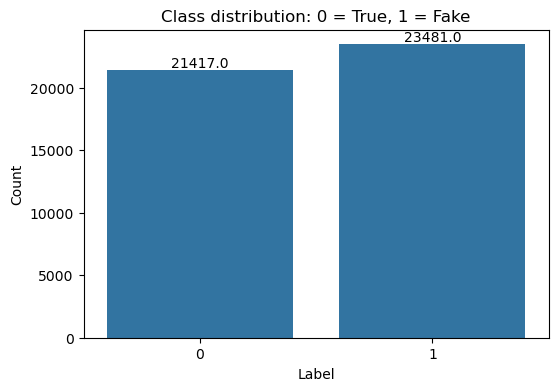


Class distribution (%):
label
1    52.298543
0    47.701457
Name: proportion, dtype: float64


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data)
plt.title('Class distribution: 0 = True, 1 = Fake')
plt.xlabel('Label')
plt.ylabel('Count')
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height}', (p.get_x()+p.get_width()/2., height), ha='center', va='bottom')
plt.show()

# Show percentages
print('\nClass distribution (%):')
print(data['label'].value_counts(normalize=True)*100)

### 2) Exploratory Data Analysis (EDA)
### We'll inspect the text columns (`title`, `text`), show sample entries, and visualize word clouds (if installed).

In [3]:
# Show few rows
display(data.sample(6).T)

,9801,12752,5404,37676,40424,11973
title,‘Far Too Sacred’ LFL Weighs In On NFL Kneeling...,DON’T BELIEVE THE MEDIA! MASSIVE FL TRUMP RALL...,Report: Trump Won’t Be Handling Foreign Or Do...,Australia's Victoria state closer to legalizin...,Greek police arrest Syrian suspected of terror...,WATCH KELLYANNE CONWAY vs Total Jerk Chris Cuo...
text,The football league formerly known as the Ling...,The media would like voters to believe that Tr...,Donald Trump is officially the Republican nomi...,SYDNEY (Reuters) - Australia s second-largest ...,ATHENS (Reuters) - Greek police said they arre...,https://www.youtube.com/watch?v=6VN1maBEKIk
subject,politics,politics,News,worldnews,worldnews,politics
date,"Sep 27, 2017","Oct 12, 2016","July 20, 2016","November 22, 2017","October 20, 2017","Jan 7, 2017"
label,1,1,1,0,0,1


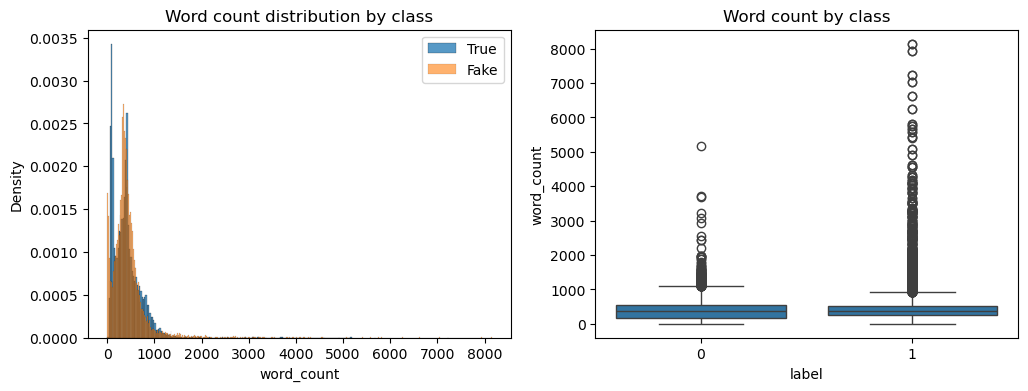

In [4]:
# Basic length features to inspect distribution
if 'text' not in data.columns:
    # Some Fake/True datasets use different column names; try 'content' or combine title+text
    print("Warning: 'text' column not found. Available columns:", data.columns.tolist())

# Create combined text column for analysis
data['content'] = data.apply(lambda r: (str(r.get('title','')) + ' ' + str(r.get('text',''))).strip(), axis=1)

# Add simple numeric features
data['content_length'] = data['content'].apply(lambda x: len(x))
data['word_count'] = data['content'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data[data['label']==0]['word_count'], label='True', kde=False, stat='density')
sns.histplot(data[data['label']==1]['word_count'], label='Fake', kde=False, stat='density', alpha=0.6)
plt.legend()
plt.title('Word count distribution by class')

plt.subplot(1,2,2)
sns.boxplot(x='label', y='word_count', data=data)
plt.title('Word count by class')
plt.show()

### Try generating word clouds (optional). If `wordcloud` is not installed, this step will be skipped gracefully.

In [5]:
try:
    from wordcloud import WordCloud
    wc_true = WordCloud(width=600, height=300, background_color='white').generate(' '.join(data[data['label']==0]['content'].astype(str).tolist()))
    wc_fake = WordCloud(width=600, height=300, background_color='white').generate(' '.join(data[data['label']==1]['content'].astype(str).tolist()))

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(wc_true, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud - True news')

    plt.subplot(1,2,2)
    plt.imshow(wc_fake, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud - Fake news')
    plt.show()
except Exception as e:
    print('Skipping word cloud (wordcloud library may not be installed).', e)

Skipping word cloud (wordcloud library may not be installed). No module named 'wordcloud'


### 3) Text Preprocessing
###  We'll clean text: remove URLs, special characters, extra spaces, lowercase, remove stopwords, lemmatize.
###  We'll show before/after examples.

In [6]:


# Preprocessing utilities imports
import re
import nltk

# Download required NLTK data (wrapped in try/except)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brahm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Define preprocessing function

def preprocess_text(text, do_lemmatize=True, remove_stopwords=True):
    """Clean and tokenize text: remove urls, non-alphanumeric chars, lower, remove stopwords, lemmatize."""
    if pd.isnull(text):
        return ''
    # convert to str
    text = str(text)
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # keep only letters and numbers
    text = re.sub(r"[^a-zA-Z0-9\s]", ' ', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # lowercase
    text = text.lower()
    # tokenize
    tokens = word_tokenize(text)
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words and len(t)>1]
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

In [8]:
# Show before/after examples on a few samples
samples = data['content'].sample(6, random_state=42).tolist()
print('Before -> After')
for s in samples:
    print('---')
    print('BEFORE:', s[:200])
    print('AFTER :', preprocess_text(s)[:200])

Before -> After
---
BEFORE: Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame
AFTER : ben stein call 9th circuit court committed coup tat constitution 21st century wire say ben stein reputable professor pepperdine university also hollywood fame appearing tv show film ferris bueller day
---
BEFORE: Trump drops Steve Bannon from National Security Council WASHINGTON (Reuters) - U.S. President Donald Trump removed his chief strategist Steve Bannon from the National Security Council on Wednesday, re
AFTER : trump drop steve bannon national security council washington reuters president donald trump removed chief strategist steve bannon national security council wednesday reversing controversial decision e
---
BEFORE: Puerto Rico expects U.S. to lift Jones Act shipping restrictions (Reuters) - Puerto Rico Governor Ricardo Rossello said on Wedne

In [ ]:
# Apply preprocessing to the dataset (this may take some time)

data['content_clean'] = data['content'].apply(lambda x: preprocess_text(x))

# Check nulls and sample cleaned
print('\nAfter cleaning — any empty contents?', (data['content_clean'].str.strip()=="").sum())
print('\nSample cleaned text:')
print(data[['content','content_clean']].sample(6).T)

### 4) Feature Engineering
###  TF-IDF (with unigrams and bigrams) and simple numeric features like text length and punctuation count.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Additional simple features
import string

def punctuation_count(s):
    if pd.isnull(s):
        return 0
    return sum(1 for ch in s if ch in string.punctuation)

# create features
data['punct_count'] = data['content'].apply(punctuation_count)
# content_length and word_count already exist

# Define TF-IDF vectorizer (unigrams + bigrams)
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=3)

# Fit-transform on cleaned content
X_tfidf = vectorizer.fit_transform(data['content_clean'].astype(str))
print('TF-IDF matrix shape:', X_tfidf.shape)

# Combine sparse TF-IDF with numeric features using scipy hstack
from scipy.sparse import hstack, csr_matrix

numeric_feats = csr_matrix(data[['content_length','word_count','punct_count']].fillna(0).values)
X = hstack([X_tfidf, numeric_feats])

# Labels
y = data['label'].values

print('Final feature matrix shape:', X.shape)

### 5) Train / Test Split
###  We'll use an 80-20 split and stratify by label. We'll create helper functions for training and evaluation.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

#### Helper functions: training, evaluation and plotting

In [ ]:
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(name, model, X_test, y_test, y_pred_proba=None):
    """Evaluate model and return metrics dict. Also plot confusion matrix and ROC curve."""
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cls_report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Print summary
    print(f"\nModel: {name}")
    print('Accuracy:', acc)
    print('\nClassification report:')
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC & AUC — try to obtain probability scores or decision function
    auc = None
    if y_pred_proba is not None:
        try:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc = roc_auc_score(y_test, y_pred_proba)
            plt.figure(figsize=(6,4))
            plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
            plt.plot([0,1],[0,1],'--')
            plt.title(f'ROC Curve - {name}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')
            plt.show()
        except Exception:
            print('Could not compute ROC/AUC for', name)

    return {'name': name, 'accuracy': acc, 'report': cls_report, 'confusion_matrix': cm, 'auc': auc}

# A generic train function that times the training

def train_and_time(model, X_train, y_train):
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    return model, end-start

### 6) Models — train and evaluate each model in its own cell

#### 6.1 Linear Regression (baseline)
#### We'll treat labels as 0/1, train LinearRegression and threshold predictions at 0.5 to get class labels.

In [ ]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg, t_lin = train_and_time(linreg, X_train, y_train)
# Predict continuous outputs and threshold
y_pred_cont = linreg.predict(X_test)
# convert to probabilities in 0-1 via clipping
y_pred_prob = np.clip(y_pred_cont, 0, 1)
# threshold
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# Evaluate
from sklearn.metrics import accuracy_score
print('Training time (s):', t_lin)
print('Accuracy (threshold 0.5):', accuracy_score(y_test, y_pred_label))
print('\nClassification report:')
print(classification_report(y_test, y_pred_label))
cm = confusion_matrix(y_test, y_pred_label)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix - LinearRegression (threshold 0.5)')
plt.show()

# ROC/AUC
try:
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    print('AUC:', roc_auc_score(y_test, y_pred_prob))
    plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.title('ROC - LinearRegression'); plt.show()
except Exception as e:
    print('ROC failed:', e)

results = []
results.append({'name':'LinearRegression','accuracy':accuracy_score(y_test,y_pred_label),'auc':roc_auc_score(y_test,y_pred_prob)})

#### 6.2 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg, t_log = train_and_time(logreg, X_train, y_train)
print('Training time (s):', t_log)
# Predict
y_proba_log = None
try:
    y_proba_log = logreg.predict_proba(X_test)[:,1]
except Exception:
    y_proba_log = logreg.decision_function(X_test)

res_log = evaluate_model('Logistic Regression', logreg, X_test, y_test, y_proba_log)
res_log['train_time_s'] = t_log
results.append(res_log)

#### 6.3 Multinomial Naive Bayes
##### Note: MultinomialNB expects non-negative features (TF-IDF is fine)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb, t_mnb = train_and_time(mnb, X_train, y_train)
print('Training time (s):', t_mnb)
try:
    y_proba_mnb = mnb.predict_proba(X_test)[:,1]
except Exception:
    y_proba_mnb = None
res_mnb = evaluate_model('MultinomialNB', mnb, X_test, y_test, y_proba_mnb)
res_mnb['train_time_s'] = t_mnb
results.append(res_mnb)

#### 6.4 Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
rfc, t_rfc = train_and_time(rfc, X_train, y_train)
print('Training time (s):', t_rfc)
try:
    y_proba_rfc = rfc.predict_proba(X_test)[:,1]
except Exception:
    y_proba_rfc = None
res_rfc = evaluate_model('Random Forest', rfc, X_test, y_test, y_proba_rfc)
res_rfc['train_time_s'] = t_rfc
results.append(res_rfc)

# Feature importance: since features are high-dimensional (TF-IDF + 3 numeric), show top numeric importances only by averaging groups
try:
    importances = rfc.feature_importances_
    # Show top 10 importances indexes
    top_idx = np.argsort(importances)[-10:][::-1]
    print('\nTop 10 feature importances (indices):', top_idx)
except Exception as e:
    print('Could not compute feature importances: ', e)

#### 6.5 Support Vector Machine (SVM)
##### We'll use a linear SVM for speed (LinearSVC) but enable probability via CalibratedClassifierCV if needed. 

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svc = LinearSVC(max_iter=5000)
# Wrap with calibration to get probabilities (this will take longer)
svc_cal = CalibratedClassifierCV(svc)
svc_cal, t_svc = train_and_time(svc_cal, X_train, y_train)
print('Training time (s):', t_svc)
try:
    y_proba_svc = svc_cal.predict_proba(X_test)[:,1]
except Exception:
    y_proba_svc = None
res_svc = evaluate_model('LinearSVC (Calibrated)', svc_cal, X_test, y_test, y_proba_svc)
res_svc['train_time_s'] = t_svc
results.append(res_svc)

#### 6.6 Gradient Boosting (sklearn)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb, t_gb = train_and_time(gb, X_train, y_train)
print('Training time (s):', t_gb)
try:
    y_proba_gb = gb.predict_proba(X_test)[:,1]
except Exception:
    y_proba_gb = None
res_gb = evaluate_model('GradientBoosting', gb, X_test, y_test, y_proba_gb)
res_gb['train_time_s'] = t_gb
results.append(res_gb)

### 7) Cross-validation (optional but recommended)
#### We'll perform cross-validation on the Logistic Regression and Random Forest to estimate stability.

In [ ]:
from sklearn.model_selection import cross_val_score

print('Cross-validating Logistic Regression (5-fold):')
cv_scores_log = cross_val_score(logreg, X, y, cv=5, scoring='f1')
print('5-fold F1 scores:', cv_scores_log)
print('Mean F1:', cv_scores_log.mean())

print('\nCross-validating Random Forest (3-fold due to time):')
cv_scores_rf = cross_val_score(rfc, X, y, cv=3, scoring='f1')
print('3-fold F1 scores:', cv_scores_rf)
print('Mean F1:', cv_scores_rf.mean())

### 8) Comparison & Visualization of Model Performance

In [ ]:
# Build comparison table from results list

rows = []
for r in results:
    if isinstance(r, dict):
        rows.append({'Model': r.get('name','unknown'), 'Accuracy': r.get('accuracy'), 'AUC': r.get('auc'), 'TrainTime_s': r.get('train_time_s', None)})
    else:
        rows.append(r)

comp_df = pd.DataFrame(rows).sort_values('Accuracy', ascending=False).reset_index(drop=True)
print(comp_df)

# Bar chart comparison
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.barplot(x='Accuracy', y='Model', data=comp_df, palette='deep')
plt.title('Model Accuracy Comparison')

plt.subplot(1,2,2)
sns.barplot(x='AUC', y='Model', data=comp_df, palette='muted')
plt.title('Model AUC Comparison')
plt.tight_layout()
plt.show()

# Identify best performing model by Accuracy then AUC
best_by_acc = comp_df.loc[comp_df['Accuracy'].idxmax()]
print('\nBest by accuracy:\n', best_by_acc)

### 9) Save best model and vectorizer for deployment (optional)
#### We will save the best model (by accuracy) and the TF-IDF vectorizer using joblib. If you prefer pickle, change accordingly.

In [ ]:
import joblib

best_model_name = comp_df.loc[comp_df['Accuracy'].idxmax()]['Model']
print('Best model name:', best_model_name)

# Map name -> actual model object
model_map = {
    'Logistic Regression': logreg,
    'MultinomialNB': mnb,
    'Random Forest': rfc,
    'LinearSVC (Calibrated)': svc_cal,
    'GradientBoosting': gb
}

best_model = model_map.get(best_model_name, None)
if best_model is not None:
    joblib.dump(best_model, 'best_model.joblib')
    joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')
    print('Saved best_model.joblib and tfidf_vectorizer.joblib')
else:
    print('Best model object not found in model_map. Please save manually if needed.')

### 10) Utilities & Inference Example
#### A small function to preprocess and predict on a single text example.

In [ ]:
def predict_text_raw(text, model, vectorizer):
    """Return predicted label and probability for a single raw text string."""
    clean = preprocess_text(text)
    X_vec = vectorizer.transform([clean])
    # add numeric features (zeros for single sample)
    numerics = np.array([[len(text), len(text.split()), punctuation_count(text)]])
    from scipy.sparse import hstack
    X_full = hstack([X_vec, csr_matrix(numerics)])
    try:
        proba = model.predict_proba(X_full)[:,1][0]
    except Exception:
        # try decision function
        try:
            proba = model.decision_function(X_full)
            # scale to 0-1
            proba = 1/(1+np.exp(-proba))[0]
        except Exception:
            proba = None
    pred = model.predict(X_full)[0]
    return {'predicted_label': int(pred), 'probability': float(proba) if proba is not None else None}

# Example usage (replace text below with any article text)
example_text = "Breaking: New discovery shows dramatic impact on climate. Experts are shocked by findings."
print('Inference example:', predict_text_raw(example_text, logreg, vectorizer))

#### Notes, Best Practices & Next Steps

#### Performance Improvements
- Apply hyperparameter tuning using techniques like `GridSearchCV` or `RandomizedSearchCV`.
- Explore advanced text representations such as word embeddings or transformer-based embeddings.
- Consider ensembling predictions from multiple models to boost accuracy.

#### Reproducibility
- Set `random_state` consistently across models and data splits to ensure reproducible results.

#### Production Considerations
- Use a smaller vocabulary or a hashing vectorizer to reduce memory usage in deployment environments.
- Incorporate additional metadata features (e.g., source, author, publish date) if available to enhance model performance.

---

**End of notebook**

If you want this converted to a `.ipynb` file, I can prepare it for download in the next response.